# Post-stack seismic inversion of Marmousi model with IntraSeismic

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pylops
from pylops.utils.wavelets import *
from intraseismic.utils import *
from intraseismic.dataset import *
from intraseismic.model import *
from intraseismic.train import *
from torchinfo import summary
import torch
import json

plt.rcParams['font.size'] = '9'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)

True

## Data Loading

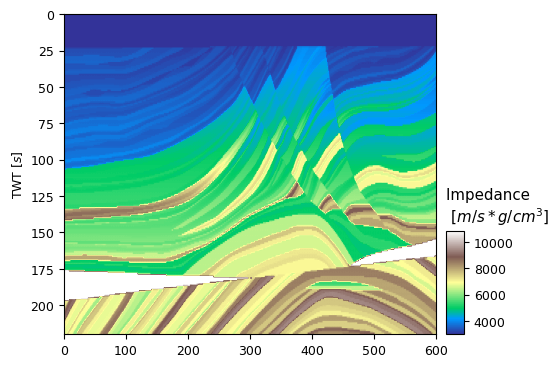

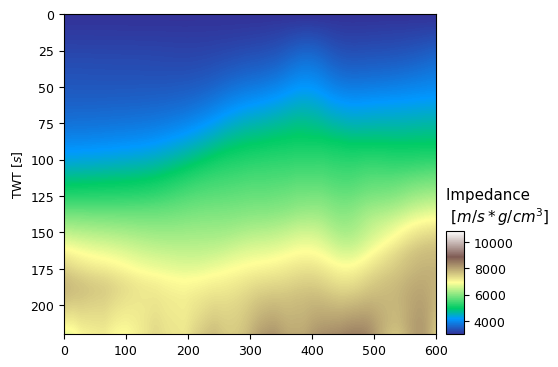

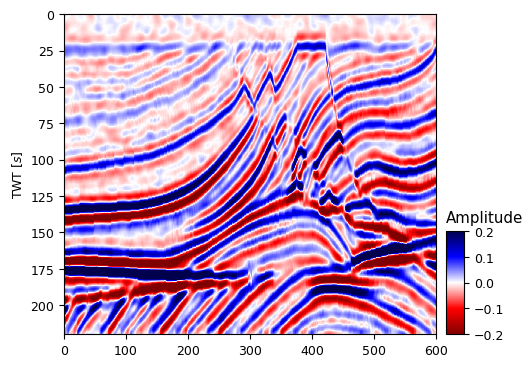

In [2]:
marm = np.load('../../data/Marmousi.npz')
d_tensor = torch.from_numpy(marm['dn1']).float().ravel() # noisy data
m_true = torch.from_numpy(marm['m_true'].astype('float32'))
mback = torch.from_numpy(np.log(marm['mback']).astype('float32')).float()
wav = marm['wav']

dims = mback.numpy().shape

vmin, vmax = np.percentile(marm['m_true'], [3, 97])
plotmodel(marm['m_true'], vmin, vmax)
plotmodel(marm['mback'], vmin, vmax)
plotdata(marm['dn1'])

## Data preparation

In [3]:
# General parameters
num_epochs = 1500
print_evry = 500
learning_rate = 1e-2

coords = create_coords(dims).to(device)
d =  d_tensor.to(device)
mback_ =  mback.ravel().to(device)

# Modeling Operator
G = pylops.avo.poststack.PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
G_torch = pylops.torchoperator.TorchOperator(G, device=device)

## IntraSeismic model setup

In [4]:
# IntraSeismic model setup
with open("config_marm.json") as f:
	config = json.load(f)
    
# IntraSeismic network 
net = create_model(n_input_dims=len(dims), n_output_dims=1, config=config).to(device)

summary(net)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Encoding: 1-1                          520,640
├─MLP: 1-2                               --
│    └─ModuleList: 2-1                   --
│    │    └─Linear: 3-1                  2,112
│    │    └─Linear: 3-2                  4,160
│    └─Linear: 2-2                       65
Total params: 526,977
Trainable params: 526,977
Non-trainable params: 0

## Training

In [5]:
# Initialize optimizer and losses
combined_parameters = list(net.parameters())
optimizer = torch.optim.Adam(combined_parameters, lr=learning_rate)

# Training Loop
total_train_time = 0
epoch_losses = []
snrs = []

for epoch in range(1, num_epochs + 1):
    net.train()
    loss, epoch_time = train_is_sb(coords, d, mback_, dims, G_torch,
                                   net, optimizer,
                                   alpha_mtv = 1e-7,
                                   beta = 1e-4)
                                                                                       
    total_train_time += epoch_time
    epoch_losses.append(loss)
    net.eval()
    with torch.no_grad():
        delta_model = net(coords.to(device))
        model_ = delta_model.squeeze(1) + mback.ravel().to(device)
        snrs.append(SNR(m_true.ravel(), torch.exp(model_).cpu()))
    
    if epoch % print_evry == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss:.6f}, Training Time: {total_train_time:.2f}s')

print(f'Training completed in {total_train_time:.3f} seconds.')

Epoch [500/1500], Loss: 0.000383, Training Time: 2.47s
Epoch [1000/1500], Loss: 0.000374, Training Time: 4.20s
Epoch [1500/1500], Loss: 0.000369, Training Time: 5.94s
Training completed in 5.944 seconds.


Text(0.5, 1.0, 'SNR')

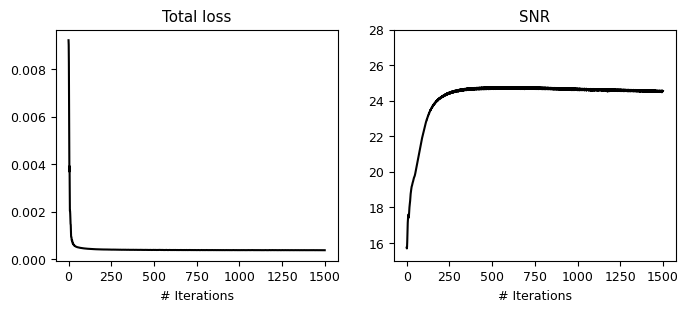

In [6]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(epoch_losses, 'k')
ax[0].set_xlabel('# Iterations')
# ax[0].set_ylim(0.0005, 0.0030)
ax[0].set_title('Total loss')
ax[1].plot(snrs, 'k')
ax[1].set_xlabel('# Iterations')
ax[1].set_ylim(15,28)
ax[1].set_title('SNR')

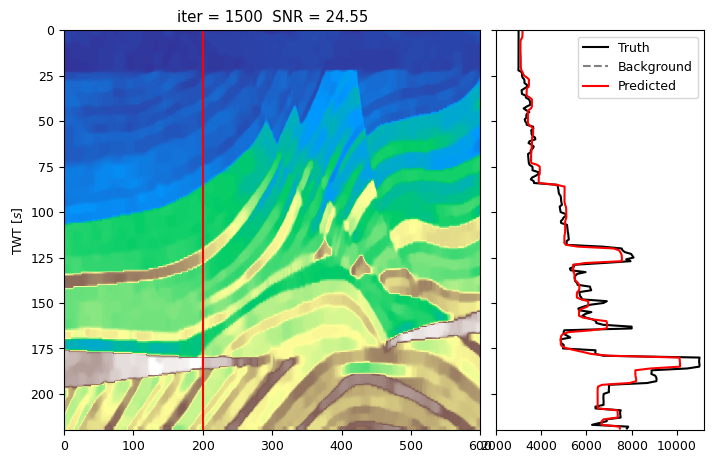

In [7]:
net.eval()
with torch.no_grad():
    delta_model = net(coords.to(device))
    model_ = delta_model.squeeze(1) + mback.ravel().to(device)

model_cpu= model_.reshape(*dims).detach().cpu()
plotresults(np.exp(model_cpu), np.exp(mback), vmin, vmax, 
            m_true=np.log(m_true), i=epoch)